# Environment setup

In [1]:
# Load the packages
import os
import sys
import gc
import gseapy
import scanpy as sc
import decoupler as dc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Set the system path
sys.path.append(os.path.abspath('../'))
from Utils.Preprocessing_scanpy import *


# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

# Load Data

In [2]:
# Load example dataset
adata = sc.read('../data/Preprocessed_data/harmony_cellmarkers.h5ad')
adata

AnnData object with n_obs × n_vars = 7736 × 33694
    obs: 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'dendrogram_cell_type', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'log_norm', 'norm', 'raw', 'scale_data'
    obsp: 'connectivities', 'distances'

# Gene set Analysis

In [3]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’
gene_set_names = gseapy.get_library_name(organism='Human')

In [5]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added = "wilcoxon")


In [6]:
adata.obs['cell_type'].value_counts()

cell_type
Stromal cell                    2089
Interstitial progenitor cell    1421
Plasma cell                     1349
Cartilage progenitor cell       1255
CD4+ T cell                      722
Neural progenitor cell           617
Regulatory chondrocyte           177
Transit-amplifying cell          106
Name: count, dtype: int64

In [12]:
glist = sc.get.rank_genes_groups_df(adata, group='Plasma cell', key='wilcoxon', log2fc_min=0.25, pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=glist, organism='Human', gene_sets='KEGG_2021_Human', cutoff = 0.5)
gseapy.barplot(enr_res.res2d, title='KEGG_2021_Human')

ValueError: Warning: No enrich terms when cutoff = 0.05

In [13]:
gene_rank = sc.get.rank_genes_groups_df(adata, group='Plasma cell', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(adata.var_names[adata.var.n_cells_by_counts>30])]

gene_rank

,names,logfoldchanges
5393,C6orf163,9.291271
11932,WWTR1-AS1,8.399954
1777,PAQR8,8.254740
2048,RP11-338I21.1,8.175735
31187,CSF2,7.749719
...,...,...
33689,UBE2S,NaN
33690,RPL39L,NaN
33691,RPS2,NaN
33692,DEK,NaN


In [14]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

terms = res.res2d.Term
terms[:10]

2024-05-24 16:00:31,464 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-05-24 16:00:31,582 [WARNING] Duplicated values found in preranked stats: 2.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


0                                      Amoebiasis
1                              Huntington disease
2       Natural killer cell mediated cytotoxicity
3                                  Bile secretion
4                          Rap1 signaling pathway
5                     Arachidonic acid metabolism
6                      JAK-STAT signaling pathway
7                       Thyroid hormone synthesis
8    Intestinal immune network for IgA production
9                             Coronavirus disease
Name: Term, dtype: object

[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

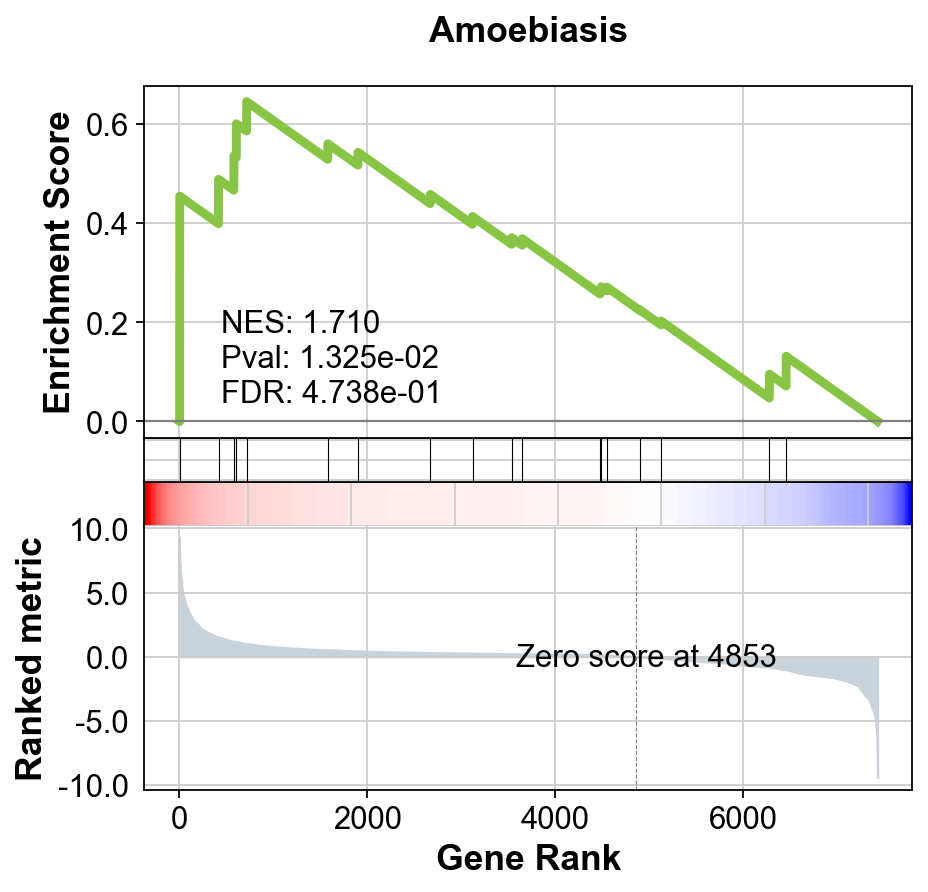

In [15]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])
